<left>FINM 33150 - Quantitative Trading Strategies</left>
<left>Winter 2023</left>
<br>
<h1><center> Homework 3: Financial Ratio Quantile Strategies </center></h1>
<center>Due - 23:00 [CST] January 26th, 2023</center>
<br>
<h3>Ki Hyun</h3>
<h3>Student ID: 12125881</h3>

<h5> Imports </h5>

In [1]:
%matplotlib inline

In [2]:
import os
from datetime import datetime, timedelta
import quandl
import functools
import pickle

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns

<h5> Constants </h5>

In [3]:
Prices_table = 'QUOTEMEDIA/PRICES'
FC_table = 'ZACKS/FC'
FR_table = 'ZACKS/FR'
MT_table = 'ZACKS/MT'
MKTV_table = 'ZACKS/MKTV'
SHRS_table = 'ZACKS/SHRS'
HDM_table = 'ZACKS/HDM'
start_date = '2015-01-01'
end_date = '2022-01-31'
banned_sectors = [5, 13]
capital = 1000000
fund_rate = 0.03

<h5> Helper Functions </h5>

<h6> <i> Grabbing Data </i> </h6>

In [4]:
"""
This code was given by Dr. Boonstra, B., Ph.D. for
University of Chicago FINM 33150 Quandl Options Data Fetching guidelines
"""
def grab_quandl_table(
    table_path,
    avoid_download=False,
    replace_existing=False,
    date_override=None,
    allow_old_file=False,
    **kwargs,
):
    if os.environ['OS'][0:7] == "Windows":
        root_data_dir = os.path.join(os.environ['HOMEPATH'], 'Quandl Data')
    else:
        root_data_dir = os.path.join(os.environ["HOME"], 'Quandl Data')
    data_symlink = os.path.join(root_data_dir, f"{table_path}_latest.zip")
    if avoid_download and os.path.exists(data_symlink):
        print(f"Skipping any possible download of {table_path}")
        return data_symlink

    table_dir = os.path.dirname(data_symlink)
    if not os.path.isdir(table_dir):
        print(f'Creating new data dir {table_dir}')
        os.mkdir(table_dir)

    if date_override is None:
        my_date = datetime.now().strftime("%Y%m%d")
    else:
        my_date = date_override
    data_file = os.path.join(root_data_dir, f"{table_path}_{my_date}.zip")

    if os.path.exists(data_file):
        file_size = os.stat(data_file).st_size
        if replace_existing or not file_size > 0:
            print(f"Removing old file {data_file} size {file_size}")
        else:
            print(
                f"Data file {data_file} size {file_size} exists already, no need to download"
            )
            return data_file

    dl = quandl.export_table(
        table_path, filename = data_file, api_key = 'JbMPn9bSpFPNS7Z7PcZy', **kwargs
    )
    file_size = os.stat(data_file).st_size
    if os.path.exists(data_file) and file_size > 0:
        print(f"Download finished: {file_size} bytes")
        if not date_override:
            try:
                if os.path.exists(data_symlink):
                    print(f"Removing old symlink")
                    os.unlink(data_symlink)
                print(f"Creating symlink: {data_file} -> {data_symlink}")
                os.symlink(
                    data_file, data_symlink,
                )
            except:
                print(f"Symlink Creation Permission Denied")
                data_symlink = data_file
    else:
        print(f"Data file {data_file} failed download")
        return
    return data_symlink if (date_override is None or allow_old_file) else "NoFileAvailable"

In [5]:
"""
This code was given by Dr. Boonstra, B., Ph.D. for
University of Chicago FINM 33150 Quandl Options Data Fetching guidelines
"""
def fetch_quandl_table(table_path, avoid_download=True, **kwargs):
    return pd.read_csv(
        grab_quandl_table(table_path, avoid_download=avoid_download, **kwargs),
        low_memory = False
    )

<h6> <i> Raw Data </i> </h6>

In [6]:
Prices = fetch_quandl_table(Prices_table, avoid_download = False)
FC = fetch_quandl_table(FC_table, avoid_download = False)
FR = fetch_quandl_table(FR_table, avoid_download = False)
MT = fetch_quandl_table(MT_table, avoid_download = False)
MKTV = fetch_quandl_table(MKTV_table, avoid_download = False)
MKTV['m_ticker'] = MKTV['m_ticker'].apply(lambda x: x.replace(" ", ""))
SHRS = fetch_quandl_table(SHRS_table, avoid_download = False)
SHRS['m_ticker'] = SHRS['m_ticker'].apply(lambda x: x.replace(" ", ""))
HDM = fetch_quandl_table(HDM_table, avoid_download = False)

Download finished: 1373380896 bytes
Creating symlink: \Users\kwhyu\Quandl Data\QUOTEMEDIA/PRICES_20230129.zip -> \Users\kwhyu\Quandl Data\QUOTEMEDIA/PRICES_latest.zip
Symlink Creation Permission Denied
Download finished: 175926758 bytes
Creating symlink: \Users\kwhyu\Quandl Data\ZACKS/FC_20230129.zip -> \Users\kwhyu\Quandl Data\ZACKS/FC_latest.zip
Symlink Creation Permission Denied
Download finished: 36386771 bytes
Creating symlink: \Users\kwhyu\Quandl Data\ZACKS/FR_20230129.zip -> \Users\kwhyu\Quandl Data\ZACKS/FR_latest.zip
Symlink Creation Permission Denied
Download finished: 993171 bytes
Creating symlink: \Users\kwhyu\Quandl Data\ZACKS/MT_20230129.zip -> \Users\kwhyu\Quandl Data\ZACKS/MT_latest.zip
Symlink Creation Permission Denied
Download finished: 6693434 bytes
Creating symlink: \Users\kwhyu\Quandl Data\ZACKS/MKTV_20230129.zip -> \Users\kwhyu\Quandl Data\ZACKS/MKTV_latest.zip
Symlink Creation Permission Denied
Download finished: 5100047 bytes
Creating symlink: \Users\kwhyu\Quan

<h6> <i> Cleaning Data </i> </h6>

In [7]:
class Ratio_Quantile:
    def __init__(self, m_ticker, price_ticker, start_date, end_date,
                 test = False):
        # inherited data
        self.ticker = m_ticker
        self.price_ticker = price_ticker
        self.start_date = start_date
        self.end_date = end_date
        self.test = test

        if self.test:
            self.flag = self.test_filing_data()

    def quarterly_data(self):
        global FC
        global FR
        global MKTV
        global SHRS
        start_date = FC[(FC['m_ticker'] == self.ticker) &
                        (FC['filing_date'] <= self.start_date) &
                        (FC['per_type'] == 'Q')]['per_end_date'].sort_values().max()
        if start_date is np.nan:
            self.flag = False
            return np.NaN
        Q1 = FC[(FC['m_ticker'] == self.ticker) & (FC['per_type'] == 'Q')].set_index('per_end_date').sort_index()\
                    .loc[start_date:self.end_date][['filing_date', 'net_lterm_debt', 'tot_lterm_debt',
                                                    'eps_diluted_net', 'basic_net_eps']]
        Q1['lterm_debt'] = Q1['net_lterm_debt'].where(Q1['net_lterm_debt'].notnull(), Q1['tot_lterm_debt'])
        Q1['lterm_debt'] =Q1['lterm_debt'].fillna(0.0)
        Q1['eps'] = Q1['eps_diluted_net'].where(Q1['eps_diluted_net'].notnull(), Q1['basic_net_eps'])
        Q1['eps'] = Q1['eps'].apply(lambda x: 0.001 if x <= 0 else x)
        Q1 = Q1.drop(['net_lterm_debt', 'tot_lterm_debt', 'eps_diluted_net', 'basic_net_eps'], axis = 1)

        Q2 = FR[(FR['m_ticker'] == self.ticker) & (FR['per_type'] == 'Q')].set_index('per_end_date').sort_index()\
                    .loc[start_date:self.end_date][['tot_debt_tot_equity', 'ret_invst']]

        Q3 = MKTV[(MKTV['m_ticker'] == self.ticker) & (MKTV['per_type'] == 'Q')].set_index('per_end_date').sort_index()\
                    .loc[start_date:self.end_date][['mkt_val']]

        Q4 = SHRS[(SHRS['m_ticker'] == self.ticker) & (SHRS['per_type'] == 'Q')].set_index('per_end_date').sort_index()\
                    .loc[start_date:self.end_date][['shares_out']]

        Q_df = Q1.merge(Q2, how = 'outer', left_index = True, right_index = True)
        Q_df = Q_df.merge(Q3, how = 'outer', left_index = True, right_index = True)
        Q_df = Q_df.merge(Q4, how = 'outer', left_index = True, right_index = True)

        return Q_df

    def annual_data(self):
        global FC
        global FR
        global MKTV
        global SHRS
        start_date = FC[(FC['m_ticker'] == self.ticker) &
                        (FC['filing_date'] <= self.start_date) &
                        (FC['per_type'] == 'A')]['per_end_date'].sort_values().max()
        if start_date is np.nan:
            self.flag = False
            return np.NaN
        A1 = FC[(FC['m_ticker'] == self.ticker) & (FC['per_type'] == 'A')].set_index('per_end_date').sort_index()\
                    .loc[start_date:self.end_date][['filing_date', 'net_lterm_debt', 'tot_lterm_debt',
                                                    'eps_diluted_net', 'basic_net_eps']]
        A1['lterm_debt'] = A1['net_lterm_debt'].where(A1['net_lterm_debt'].notnull(), A1['tot_lterm_debt'])
        A1['lterm_debt'] = A1['lterm_debt'].fillna(0.0)
        A1['eps'] = A1['eps_diluted_net'].where(A1['eps_diluted_net'].notnull(), A1['basic_net_eps'])
        A1['eps'] = A1['eps'].apply(lambda x: 0.001 if x <= 0 else x)
        A1 = A1.drop(['net_lterm_debt', 'tot_lterm_debt', 'eps_diluted_net', 'basic_net_eps'], axis = 1)

        A2 = FR[(FR['m_ticker'] == self.ticker) & (FR['per_type'] == 'A')].set_index('per_end_date').sort_index()\
                    .loc[start_date:self.end_date][['tot_debt_tot_equity', 'ret_invst']]

        A3 = MKTV[(MKTV['m_ticker'] == self.ticker) & (MKTV['per_type'] == 'A')].set_index('per_end_date').sort_index()\
                    .loc[start_date:self.end_date][['mkt_val']]

        A4 = SHRS[(SHRS['m_ticker'] == self.ticker) & (SHRS['per_type'] == 'A')].set_index('per_end_date').sort_index()\
                    .loc[start_date:self.end_date][['shares_out']]

        A_df = A1.merge(A2, how = 'outer', left_index = True, right_index = True)
        A_df = A_df.merge(A3, how = 'outer', left_index = True, right_index = True)
        A_df = A_df.merge(A4, how = 'outer', left_index = True, right_index = True)

        return A_df

    def sort_filing_data(self):
        ## Computing Quarterly/Annual Data
        self.Q_df = self.quarterly_data()
        self.A_df = self.annual_data()

        try:
            len(self.Q_df)
        except:
            self.flag = False
            return np.NaN

        try:
            len(self.A_df)
        except:
            self.flag = False
            return np.NaN

        filing_df = self.Q_df.copy()
        Temp_A = self.A_df.copy()
        Temp_A = Temp_A.reindex_like(filing_df).fillna(method = 'ffill')

        filing_df[filing_df.isna().any(axis = 1)] = Temp_A[filing_df.isna().any(axis = 1)]
        filing_df = filing_df.rename(columns = {'filing_date':'date'})

        return filing_df.reset_index().set_index('date').sort_index()

    def price_data(self):
        global Prices
        start_date = FC[(FC['m_ticker'] == self.ticker) &
                        (FC['filing_date'] <= self.start_date) &
                        (FC['per_type'] == 'A')]['per_end_date'].sort_values().max()

        if start_date is np.nan:
            self.flag = False
            return np.NaN, False

        ret_df = Prices[Prices['ticker'] == self.price_ticker][['date', 'adj_close']]
        price_start_date_flag = (ret_df['date'].min() > start_date)
        return ret_df.set_index('date').sort_index().loc[start_date:self.end_date], price_start_date_flag

    def test_filing_data(self):
        ## Computing aggregate filing data
        self.filing_df = self.sort_filing_data()
        ## Price Data
        temp = self.price_data()
        self.price_df = temp[0]

        try:
            len(self.filing_df)
        except:
            return False

        if self.filing_df.isna().any(axis = 1).sum() != 0:
            return False
        elif temp[1]:
            return False
        else:
            return True

    def final_data(self):
        # computed data
        if not self.test:
            ## Sorted Filing Data
            self.filing_df = self.sort_filing_data()
            ## Price Data
            self.price_df = self.price_data()[0]

        ret_df = self.price_df.merge(self.filing_df, how = 'outer', left_index = True, right_index = True)\
                    .fillna(method = 'ffill')
        ret_df = ret_df.shift()
        ret_df['adj_close'] = ret_df['adj_close'].shift(-1)

        ret_df['per_end_date'] = ret_df['per_end_date'].fillna(method = 'bfill')

        base_price = []
        for date in ret_df['per_end_date']:
            base_price.append(ret_df.loc[:date]['adj_close'][-1])

        ret_df['base_price'] = pd.Series(base_price, index = ret_df.index)

        return ret_df.loc[self.start_date:self.end_date]

    def compute_ratios(self):
        ## Compiled Data for ratio computing
        self.df = self.final_data()

        df = self.df.copy()
        df['debt to market cap'] = df['tot_debt_tot_equity'] * df['base_price'] /df['adj_close']
        df['M'] = df['mkt_val'] / df['base_price'] * df['adj_close']
        df['return on investment'] = df['ret_invst'] * (df['lterm_debt'] + df['mkt_val']) / (df['lterm_debt'] + df['M'])
        df['price to earnings'] = df['M'] / (df['eps'] * df['shares_out'])
        df['ticker'] = self.price_ticker
        df = df.reset_index().set_index(['date', 'ticker'])
        df = df[['adj_close', 'debt to market cap', 'return on investment', 'price to earnings']]

        return df

In [8]:
def select_tickers(start_date, end_date, banned_sectors,
                   sample_size, seed,
                   save_file = True, read_file = False):
    global Prices
    global FC
    global FR
    global MT
    global MKTV
    global SHRS
    # read file
    if read_file:
        dir = r'./data/selected_tickers_' + str(sample_size) + 'N_' + str(seed) + 's.pkl'
        with open(dir, 'rb') as f:
            try:
                ret_list = pickle.load(f)
                print(">>> Found data with matching sample size and seed...")
                return ret_list
            except:
                print(">>> No data with the selected sample size and seed")
                print(">>> Proceeding to compute the data...")
    # filter for United States equities
    filter1 = set(MT[MT['country_name'] == 'UNITED STATES']['ticker'].unique())
    # filter for available adj end of day prices data
    filter2_1 = set(Prices[(Prices['date'] <= start_date) | (Prices['date'] >= end_date)].dropna()['ticker'].unique())
    filter2_2 = set(Prices[(Prices['date'] > start_date) & (Prices['date'] < end_date)].dropna()['ticker'].unique())
    filter2 = filter2_1.intersection(filter2_2)
    # filter for debt/market_cap greater than 0.1 somewhere in the period
    filter3 = set(FR[(FR['per_end_date'] >= start_date) & (FR['per_end_date'] <= end_date) &
                 (FR['tot_debt_tot_equity'] > 0.1)]['ticker'].unique())
    # filter for automotive and financial sectors
    filter4 = set(FC[(FC['per_end_date'] >= start_date) & (FC['per_end_date'] <= end_date) &
                 (FC['zacks_sector_code'].apply(lambda x:
                                                False if x in banned_sectors else True))]['ticker'].unique())
    # filter for reasonable dates on fundamentals
    filter5_1 = set(FC[FC['filing_date'] <= start_date]['ticker'].unique())
    filter5_2 = set(FC[FC['per_end_date'] >= end_date]['ticker'].unique())
    filter5 = filter5_1.intersection(filter5_2)
    # filter for at least one PER_END_DATE no more than one year old
    min_last_date = str(int(end_date.split('-')[0]) - 1) + end_date[4:]
    filter6_1 = set(FC[FC['per_end_date'] >= min_last_date]['ticker'].unique())
    filter6_2 = set(FR[FR['per_end_date'] >= min_last_date]['ticker'].unique())
    filter6_3 = set(MKTV[MKTV['per_end_date'] >= min_last_date]['ticker'].unique())
    filter6_4 = set(SHRS[SHRS['per_end_date'] >= min_last_date]['ticker'].unique())
    filter6 = filter6_1.intersection(filter6_2, filter6_3, filter6_4)
    # filter so far:
    filter = list(filter1.intersection(filter2, filter3, filter4, filter5, filter6))
    #print(len(filter))
    # return list of Raio_Quantile classes:
    ret_list = []
    # setting seed
    np.random.seed(seed)
    flag = 0
    while(flag < sample_size):
        print("# of Tickers in list: ", len(filter))
        candidates = np.random.choice(filter, size = sample_size - flag, replace = False)
        for ticker in candidates:
            for m_ticker in FC[FC['ticker'] == ticker]['m_ticker'].unique():
                print(">>> On Ticker: ", ticker)
                temp = Ratio_Quantile(m_ticker, ticker, start_date, end_date, test = True)
                if temp.flag:
                    ret_list.append(temp)
                    flag += 1
                    print(">>> Ticker added: ", ticker)
                else:
                    print(">>> Ticker skipped: ", ticker)

            filter.remove(ticker)
        print("# of Ticker added: ", flag)

    print(">>> ", sample_size, " Tickers selected sucessfully.")

    if save_file:
        dir = r'./data/selected_tickers_' + str(sample_size) + 'N_' + str(seed) + 's.pkl'
        with open(dir, 'wb') as f:
            pickle.dump(ret_list, f)

    return ret_list

In [9]:
def trading_data(tickers, sample_size, seed, save_file = True, read_file = False):
    if read_file:
        dir = r'./data/quant_df_' + str(sample_size) + 'N_' + str(seed) + 's.csv'
        try:
            quant_df = pd.read_csv(dir)
            print(">>> Found data with matching sample size and seed...")
            return quant_df.set_index(['date', 'ticker'])
        except:
            print(">>> No data with the selected sample size and seed")
            print(">>> Proceeding to compute the data...")

    first_trial = True

    for ticker in tickers:
        #print(i)
        if first_trial:
            quant_df = ticker.compute_ratios()
            first_trial = False
        else:
            quant_df = quant_df.combine_first(ticker.compute_ratios())

    if save_file:
        dir = r'./data/quant_df_' + str(sample_size) + 'N_' + str(seed) + 's.csv'
        quant_df.to_csv(dir)

    return quant_df

<h6> <i> Trading Simulation </i> </h6>

In [10]:
def quantile_trading(ratio, df, low_to_high_rank = True):
    global fund_rate
    global capital
    ret_df = {'Date': [], 'Position': [], 'Short Position': [], 'Long Position': [], 'Interest': [], 'Daily Profit': []}
    dates = df.index.get_level_values(0).unique()
    this_month = dates[0][5:7]
    first_day = True
    yesterday_position = 0
    for day in dates:
        temp = df.loc[day].copy()
        if day[5:7] != this_month:
            first_day = True
            this_month = day[5:7]
        if first_day:
            temp['rank'] = temp[ratio].rank(ascending = low_to_high_rank)
            short_weights = temp['rank'].apply(lambda x: max(0.5*(21 - x), 0)/105) * (50000/temp['adj_close'])
            long_weights = temp['rank'].apply(lambda x: max(0.5*(x - 180), 0)/105) * (50000/temp['adj_close'])
            yesterday_position = 0
            first_day = False

        short_position = -sum(temp['adj_close'] * short_weights)
        long_position = sum(temp['adj_close'] * long_weights)
        position = long_position + short_position
        interest = short_position * (fund_rate - 0.01)/365
        profit = position - yesterday_position + interest

        ret_df['Date'].append(day)
        ret_df['Position'].append(position)
        ret_df['Short Position'].append(short_position)
        ret_df['Long Position'].append(long_position)
        ret_df['Interest'].append(interest)
        ret_df['Daily Profit'].append(profit)

        yesterday_position = position

    ret_df = pd.DataFrame(ret_df)
    ret_df['Date'] = pd.to_datetime(ret_df['Date'])
    ret_df = ret_df.set_index('Date')
    ret_df['Capital'] = capital + ret_df['Daily Profit'].cumsum()
    ret_df['Daily ROC'] = ret_df['Capital'] / ret_df['Capital'].shift() - 1

    return ret_df

In [11]:
def monthly_changes(ratio, df, low_to_high_rank = False):
    df_temp = df.copy()
    dates = df_temp.index.get_level_values(0).unique()
    this_month = dates[0][5:7]
    tag = dates[0][:8] + '32'
    first_day = True
    first_month = True
    for day in dates:
        if day[5:7] != this_month:
            first_day = True
            this_month = day[5:7]

        if first_month:
            last_month_values = df_temp.loc[day][ratio]
            first_month = False
            first_day = False
        elif first_day:
            temp1 = df_temp.loc[day][ratio]
            temp2 = temp1 - last_month_values
            df_temp.loc[day][ratio].update(temp2)
            last_month_values = temp1
            first_day = False

    return quantile_trading(ratio, df_temp.loc[tag:], low_to_high_rank)

In [12]:
def two_ratios(combination, df, low_to_high_rank = False):
    df_temp = df.copy()
    dates = df_temp.index.get_level_values(0).unique()
    df_temp['combination'] = np.NaN
    for day in dates:
        for ratio, multiplier in combination.items():
            mu = df_temp.loc[day][ratio].mean()
            sigma = df_temp.loc[day][ratio].std()
            z_score = (df_temp.loc[day][ratio] - mu)/sigma * multiplier
            temp = df_temp.loc[day]['combination'].fillna(0.0) + z_score
            df_temp.loc[day]['combination'].update(temp)

    return quantile_trading('combination', df_temp, low_to_high_rank)

In [13]:
def summary_statistics(return_series, interval, days = None):
    global capital
    ret_df = pd.DataFrame(dtype = float)
    return_series = return_series.dropna()

    if interval == 'daily':
        multiplier = 365
    elif interval == 'monthly':
        multiplier = 12
    elif interval == 'annually':
        multiplier = 1
    elif interval == 'custom':
        multiplier = 365/days
    else:
        print("Please choose interval between 'daily', 'monthly', 'annually', and 'custom'")
        return 0

    ret_df[r'Annualized $\mu$'] = return_series.mean() * multiplier
    ret_df[r'Annualized $\sigma$'] = return_series.std() * np.sqrt(multiplier)
    ret_df['Sharpe Ratio'] = ret_df[r'Annualized $\mu$'] / ret_df[r'Annualized $\sigma$']
    ret_df['Skewness'] = return_series.skew()
    ret_df['Excess Kurtosis'] = return_series.kurtosis()
    ret_df['VaR (0.025)'] = return_series.quantile(0.025)
    ret_df['CVaR (0.025)'] = return_series[return_series <= return_series.quantile(0.025)].sum()
    ret_df['Min'] = return_series.min()
    ret_df['Max'] = return_series.max()

    wealth_index = capital * (1 + return_series).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks

    ret_df['Max Drawdown'] = drawdowns.min()

    return ret_df

<h6> <i> Plot </i> </h6>

In [14]:
def abhline(y_intercept, line_style, color):
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = np.repeat(y_intercept, len(x_vals))
    plt.plot(x_vals, y_vals, line_style, color = color)

<h2> 2. Data </h2>

<h3> 2-1. Raw Data </h3>

There were 7 total raw dataset imported from Quandl for this analysis.

6 tables were imported from <a href = 'https://data.nasdaq.com/databases/ZFB/documentation?anchor=product-overview'>
Zacks Fundamentals B </a>. The tables in total contain over 200 fundamental indicators for 19,500 U.S. and Canadian
Equities. The Master Table (MT) was used for filtering country and industry. Then, the Fundamentals Condensed (FC),
Fundamental Ratios (FR), Market Value Supplement (MKTV), and Shares Out Supplement (SHRS) tables were mainly used to
filter for dates and compute the ratios.

1 table was imported from <a href = 'https://data.nasdaq.com/publishers/QUOTEMEDIA'> Quote Media Prices </a>. This
table was used to reference end-of-day adjusted closing price for each stock.

<h3> 2-2. Data Processing </h3>

<h4> <i> Filtering tickers </i> </h4>

In [15]:
#tickers = select_tickers(start_date, end_date, banned_sectors, sample_size = 200, seed = 81, save_file = True)
tickers = select_tickers(start_date, end_date, banned_sectors, sample_size = 200, seed = 81, read_file = True)

>>> Found data with matching sample size and seed...


A total of 6 filters were used to filter the equity appropriate for analysis.
- US equity
- End-of-day adjusted closing prices are available over the entire desired period of January 2015 - January 2022
- Debt/Market Capitalization Ratio is greater than 0.1 at least once during the desired period
- The equity was never involved in automotive, financial, or insurance sector over the desired period
- The given data for the equity is able to compute debt to market cap, return on investment, and price to earning
ratios over the entire desired period
- Fundamentals data for the equity involves a period end date no more than one year old from January 2022

<h4> <i> Computing Ratios </i> </h4>

In [16]:
#quant_df = trading_data(tickers, sample_size = 200, seed = 81, save_file = True)
quant_df = trading_data(tickers, sample_size = 200, seed = 81, read_file = True)

>>> Found data with matching sample size and seed...


After applying the filter, 200 equities in random (with seed set as 81) were selected for quantile trading analysis.
For the 200 equities, the debt to market cap, return on investment, and price to earning ratios were computed as
shown below, for each day of the desired period.

Notation regarding equity $i$:
- $T$: Today

- $P^i_t$: Price of equity on day $t$

- $f_T = \max \{t < T \mid \text{Filing Date}\}$

- $p_T = \max \{t \leq f_T \mid \text{Period End Date}\}$

- $\left(\frac{D}{M}\right)^i_t$ Debt to Market Capital on day $t$

- $D^i_t$: Total Debt on day $t$

- $M^i_t$: Total Equity/Market Capital on day $t$

- $ROI^i_t$: Return on investment on day $t$

- $\left(\frac{P}{E}\right)^i_t$: P/E Ratio on day $t$

- $EPS^i_t$: Earnings per Share on day $t$

- $S^i_t$: Shares Outstanding on day $t$

<h5> <u> Debt to Market Cap </u> </h5>

Adjusted end-of-day closing prices are available daily.
Total Debt to Total Market Capital ratios are updated every filing day.
Total debt was assumed constant between filing days but total market capital assumed changing daily based on equity
price.
Therefore, debt to market cap ratio could be computed as:

$$
\left(\frac{D}{M}\right)^i_T = \left(\frac{D}{M}\right)^i_{p_T} \times \frac{P^i_{p_T}}{P^i_T}
$$

<h5> <u> Return on Investment </u> </h5>

Adjusted end-of-day closing prices are available daily.
Return on Investment ratios are updated every filing day.
Total debt was assumed constant between filing days but total market capital assumed changing daily based on equity
price.
Therefore, debt to market cap ratio could be computed as:

$$
ROI^i_T = ROI^i_{p_T} \times \frac{D^i_{p_T} + M^i_{p_T}}{D^i_{p_T} + M^i_{p_T} \times \frac{P^i_T}{P^i_{p_T}}
$$

<h5> <u> Price to Earnings </u> </h5>

Adjusted end-of-day closing prices are available daily.
Earnings per Share, Shares Outstanding, and Market Capital were updated daily
Earnings per Share and Shares Outstanding were assumed constant between filing days but total market capital assumed
changing daily based on equity price.
Therefore, price to earnings ratio could be computed as:

$$
\left(\frac{P}{E}\right)^i_T = \frac{M^i_{p_T}}{EPS^i_{p_T} \cdot S^i_{p_T}} \times \frac{P^i_T}{P^i_{p_T}
$$

Computing the ratios like above gave daily values for each of the 200 chosen equities.
All the computed ratios were compiled into a single dataset using multi-level indexing.
Two index levels were used: date and ticker symbol.

<h3> 2-3. Data Description </h3>

In [17]:
quant_df.head()

adj_close  debt to market cap  return on investment  \
date       ticker                                                        
2015-01-02 AAL     51.072326            2.256998              2.983604   
           AAWW    48.420000            1.004307              0.644250   
           ABG     76.090000            1.878924              2.550206   
           ACM     30.033958            0.491293              2.251344   
           ACNT    16.589581            0.189350              2.380600   

                   price to earnings  
date       ticker                     
2015-01-02 AAL             42.221938  
           AAWW            44.014741  
           ABG             70.451375  
           ACM             47.424309  
           ACNT           128.556402

In [18]:
print("Number of columns: ", quant_df.shape[0])
print("Number of rows: ", quant_df.shape[1])

Number of columns:  356600
Number of rows:  4


The completed dataframe contains 2 indexes (date, ticker), 4 columns (adjusted closing price, debt to market cap
ratio, return on investment, price to earnings), and 1783 trading days $\times$ 200 equities $=$ 35660 rows.

The first five rows of the dataset are shown above.

<h2> 3. Analysis </h2>

The monthly quantile trading strategies for each of the 3 ratios and the combination of Price to Earnings and Return
on investment will be analyzed.

The initial capital was set as 1,000,000 USD. Thus, the first month's set of positions were 50,000 USD in both short
and long positions of the top and bottom deciles, respectively.

The fixed fund rate of $0.03$ was used for analysis. Thus, the daily repo rate for short positions were calculated as
$\frac{0.03 - 0.01}{365}$.

All position that were entered at the beginning of the month were flattened at the end of the month. Moreover, each
month, 50,000 USD of new positions were re-entered, each in long and short positions, based on the updated rank.

For the ranking based on changes strategy, the rank was given based on the total change in ratio over the previous
month. Therefore, the first entry month was February 2015 (with the same notional amount in long and short positions
as the ranking by value strategy).

The weight of the short positions for equity $i$ based on rank at time $t$ was selected as below:

$$
w^{i, short}_t = \frac{\$ 50,000}{P^i_t} \times \left( \frac{\max \{ 0.5(21 - rank^i_t), 0 \}}{105} \right)
$$

The weight of the long positions for equity $i$ based on rank at time $t$ was selected as below:

$$
w^{i, long}_t = \frac{\$ 50,000}{P^i_t} \times \left( \frac{\max \{ 0.5(rank^i_t - 180), 0 \}}{105} \right)
$$

The weights were chosen as such to put more notional USD amount invested in equities with more extreme rank.

To complete the quantile trading strategy, we need to assess, for each ratio, whether a higher value is more
desirable and whether a higher monthly difference is desirable.

Since this quant trading strategy shorts the top 10% rankings and buys the bottom 10% rankings, the less desirable
equities' ratios/ changes in ratio should be ranked higher (lower rank number) and the more desirable ranked lower
(higher rank number).

<h3> 3-1. Debt to Market Cap </h3>

<h4> <i> Ranking by Value </i> </h4>

In [19]:
trading_df1 = quantile_trading('debt to market cap', quant_df, low_to_high_rank = True)

Looking at the relationship between Debt to Market Cap ratio and Leverage Ratio:

$$
Leverage := \frac{D}{D + M} = \frac{1}{1 + \frac{M}{D}} = \frac{1}{1 + \frac{1}{\frac{D}{M}}}
$$

This would mean that a higher Debt to Market Cap ratio would also indicate a higher leverage ratio as well.

Higher leverage can be literally translated to higher liability; however, it is not necessarily a bad thing. For
instance, most tech companies try and maintain a high leverage to maintain control of the company and its projects.

For this analysis higher rank (lower rank number) was given to lower Debt to Market Cap ratio to be shorted and
visa-versa.

The performance of this strategy is shown below.

<h5> <u> Capital </u> </h5>

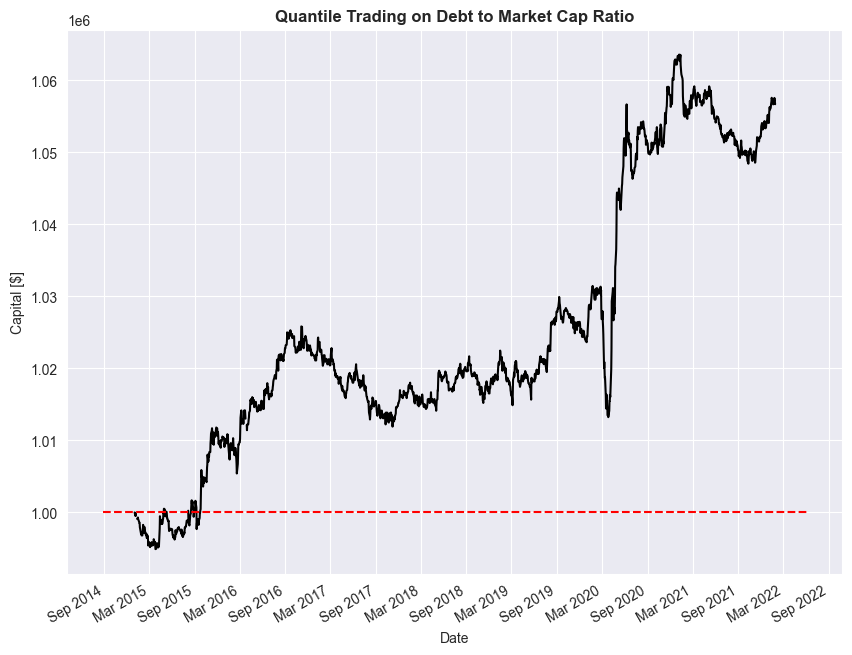

In [20]:
# set figure window
fig = plt.figure(figsize=(10,8))
# set axis
ax  = fig.add_subplot(111)
# time-series plot
ax.plot(trading_df1['Capital'], color = "black")
# capital line
abhline(capital, '--', 'red')
# x axis ticks and labels
ax.set_xlabel("Date", fontsize=10)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gcf().autofmt_xdate()
# y axis labels
ax.set_ylabel("Capital [$]", fontsize=10)
# title
ax.set_title("Quantile Trading on Debt to Market Cap Ratio", fontsize=12, fontweight = "bold")

None

The capital time-series plot shows that there is a gradual increase in capital and a huge jump from March 2020 to
August 2020, following a sharp drop around February 2020.

<h5> <u> Performance Summary </u> </h5>

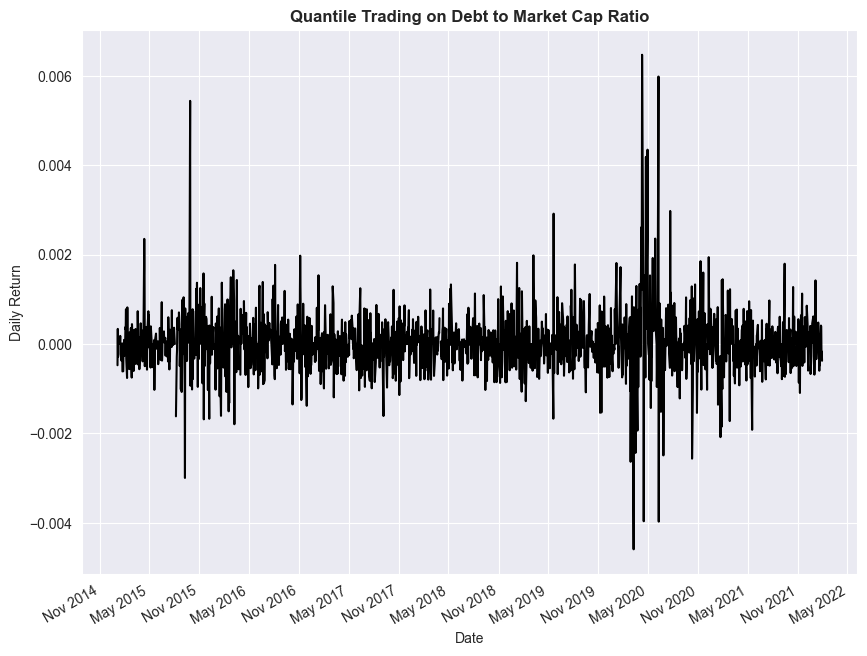

In [21]:
# set figure window
fig = plt.figure(figsize=(10,8))
# set axis
ax  = fig.add_subplot(111)
# time-series plot
ax.plot(trading_df1['Daily ROC'], color = "black")
# x axis ticks and labels
ax.set_xlabel("Date", fontsize=10)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gcf().autofmt_xdate()
# y axis labels
ax.set_ylabel("Daily Return", fontsize=10)
# title
ax.set_title("Quantile Trading on Debt to Market Cap Ratio", fontsize=12, fontweight = "bold")

None

In [22]:
summary_statistics(trading_df1[['Daily ROC']], interval = 'daily')

,Annualized $\mu$,Annualized $\sigma$,Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.025),CVaR (0.025),Min,Max,Max Drawdown
Daily ROC,0.011441,0.012939,0.884218,1.134193,15.150422,-0.001081,-0.080315,-0.004596,0.006469,-0.017669


The summary statistics show that the annualized volatility is very high.
However, the 0.025 VaR and CVaR values are not very low and the Maximum Drawdown (around the beginning of COVID19)
was approximately -1.77%.
Given that the annualized average return is very low, it is not a very reliable investment strategy and most of the
profit gained from this simulation has to be accredited to the sudden gains during COVID19.

<h4> <i> Ranking by Changes </i> </h4>

In [23]:
trading_df1_2 = monthly_changes('debt to market cap', quant_df, low_to_high_rank = False)

A lower or even negative change in Debt to Market Cap ratio would mean that the market capitalization relatively
increased. This would signal the market that the company is confident and therefore would make the equity desirable.

Thus, lower changes in Debt to Market Cap ratio were given lower ranks (higher rank numbers) to buy and visa-versa.

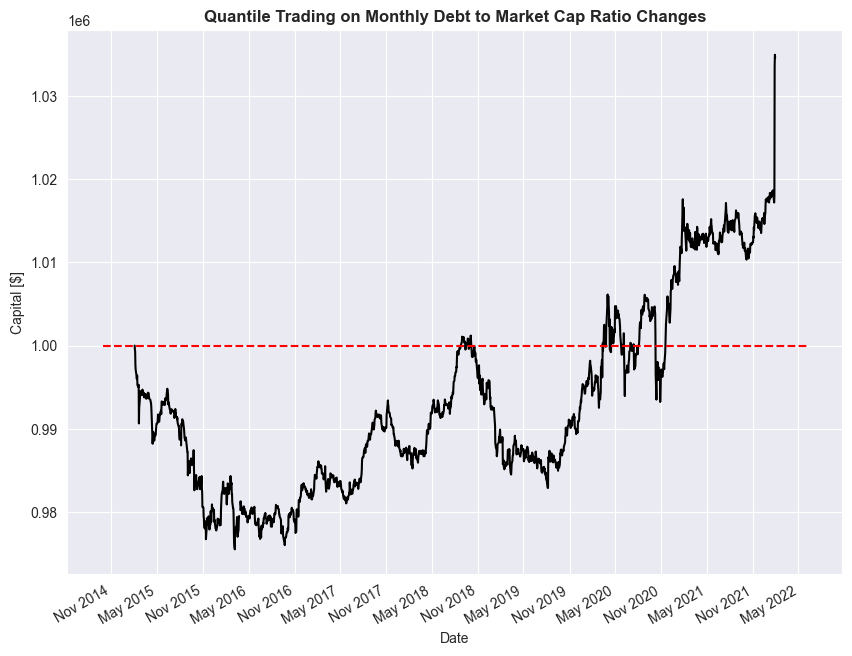

In [24]:
# set figure window
fig = plt.figure(figsize=(10,8))
# set axis
ax  = fig.add_subplot(111)
# time-series plot
ax.plot(trading_df1_2['Capital'], color = "black")
# capital line
abhline(capital, '--', 'red')
# x axis ticks and labels
ax.set_xlabel("Date", fontsize=10)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gcf().autofmt_xdate()
# y axis labels
ax.set_ylabel("Capital [$]", fontsize=10)
# title
ax.set_title("Quantile Trading on Monthly Debt to Market Cap Ratio Changes", fontsize=12, fontweight = "bold")

None

The capital time-series plot shows, following a decrease from January 2015 to July 2016, a gradual increase in capital
with many fluctuations. Towards January 2022, there is a sudden increase in capital.

<h5> <u> Performance Summary </u> </h5>

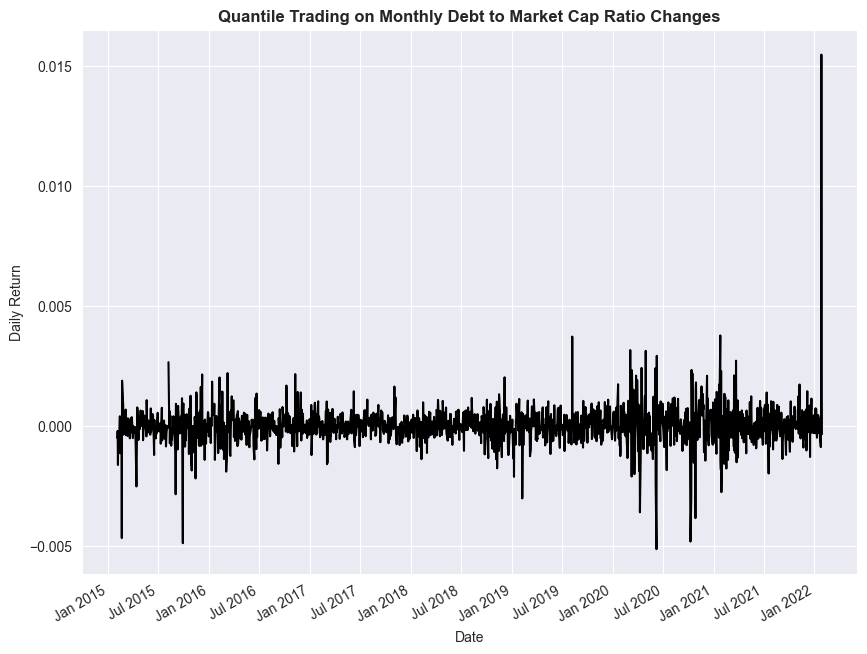

In [25]:
# set figure window
fig = plt.figure(figsize=(10,8))
# set axis
ax  = fig.add_subplot(111)
# time-series plot
ax.plot(trading_df1_2['Daily ROC'], color = "black")
# x axis ticks and labels
ax.set_xlabel("Date", fontsize=10)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gcf().autofmt_xdate()
# y axis labels
ax.set_ylabel("Daily Return", fontsize=10)
# title
ax.set_title("Quantile Trading on Monthly Debt to Market Cap Ratio Changes", fontsize=12, fontweight = "bold")

None

In [26]:
summary_statistics(trading_df1_2[['Daily ROC']], interval = 'daily')

,Annualized $\mu$,Annualized $\sigma$,Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.025),CVaR (0.025),Min,Max,Max Drawdown
Daily ROC,0.007181,0.015201,0.472441,3.683751,85.151222,-0.001383,-0.097929,-0.005135,0.015458,-0.023538


Though the annualized volatility is slightly higher than the quantile trades on Debt to Market Cap, this portfolio
shows a much lower annualized return. The VaR, CVaR, and Max Drawdown values are lower than the quantile trading
portfolio not using changes.

Therefore, it seems from the analyzed data that quantile trading portfolio based on Debt to Market Cap changes is not
only less profitable, but also riskier.

<h3> 3-2. Return on Investment </h3>

<h4> <i> Ranking by Value </i> </h4>

In [27]:
trading_df2 = quantile_trading('return on investment', quant_df, low_to_high_rank = True)

A company with a high return on investment is more valuable than a company with a low return on investment.
Therefore, the obvious strategy is to short the equities with low return on investment and long the equities with
high return on investment.

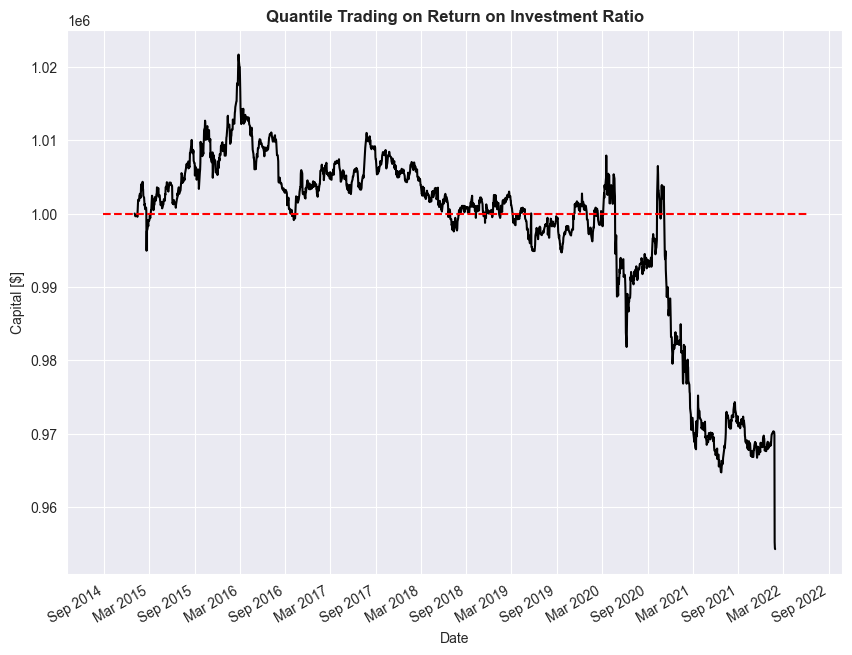

In [28]:
# set figure window
fig = plt.figure(figsize=(10,8))
# set axis
ax  = fig.add_subplot(111)
# time-series plot
ax.plot(trading_df2['Capital'], color = "black")
# capital line
abhline(capital, '--', 'red')
# x axis ticks and labels
ax.set_xlabel("Date", fontsize=10)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gcf().autofmt_xdate()
# y axis labels
ax.set_ylabel("Capital [$]", fontsize=10)
# title
ax.set_title("Quantile Trading on Return on Investment Ratio", fontsize=12, fontweight = "bold")
None

The portfolio showed mostly positive gains up to March 2020.
However, the portfolio shows mostly negative gains afterwards.

<h5> <u> Performance Summary </u> </h5>

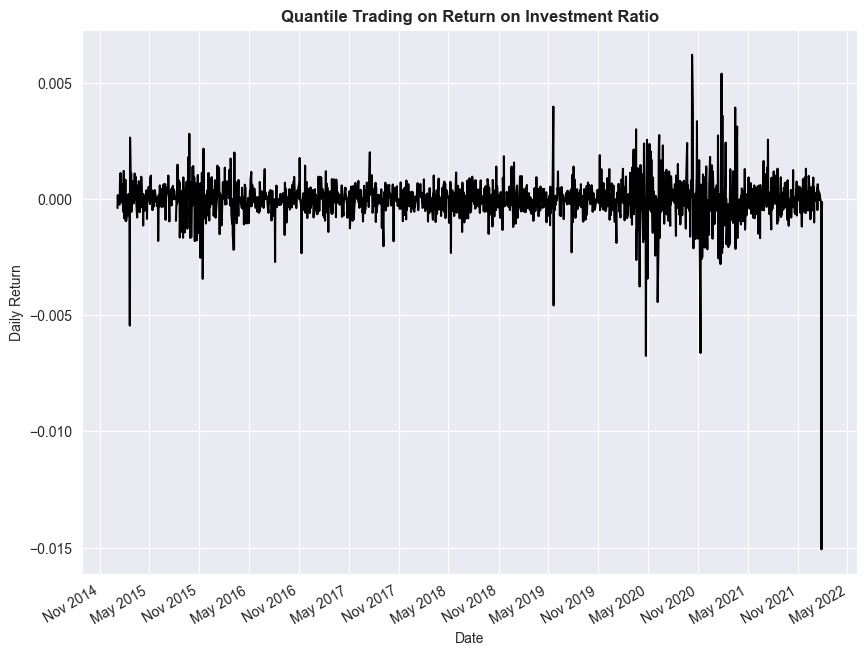

In [29]:
# set figure window
fig = plt.figure(figsize=(10,8))
# set axis
ax  = fig.add_subplot(111)
# time-series plot
ax.plot(trading_df2['Daily ROC'], color = "black")
# x axis ticks and labels
ax.set_xlabel("Date", fontsize=10)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gcf().autofmt_xdate()
# y axis labels
ax.set_ylabel("Daily Return", fontsize=10)
# title
ax.set_title("Quantile Trading on Return on Investment Ratio", fontsize=12, fontweight = "bold")

None

In [30]:
summary_statistics(trading_df2[['Daily ROC']], interval = 'daily')

,Annualized $\mu$,Annualized $\sigma$,Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.025),CVaR (0.025),Min,Max,Max Drawdown
Daily ROC,-0.009655,0.017161,-0.562609,-2.945457,51.927118,-0.001717,-0.131359,-0.015072,0.006216,-0.066328


Surprisingly the annualized return is negative.
Even if we disregard the very low minimum return value, the returns show negative skewness and high CVaR values.
Together with the negative mean, it seems like this strategy is a failure.

One possible explanation is that the market might have been over-heated for high earning company's equities. The
entry point for the position may have also not been desirable since it was force set to the beginning of each month.

A closer look into the ranking by return on investment ratio changes and the P/E ratio is needed to explain for the
loss.

<h4> <i> Ranking by Changes </i> </h4>

In [31]:
trading_df2_2 = monthly_changes('return on investment', quant_df, low_to_high_rank = True)

Similar to before, the obvious strategy is to buy the equities that reported increase in return on investment and
short the ones with lower/decrease in return on investment.

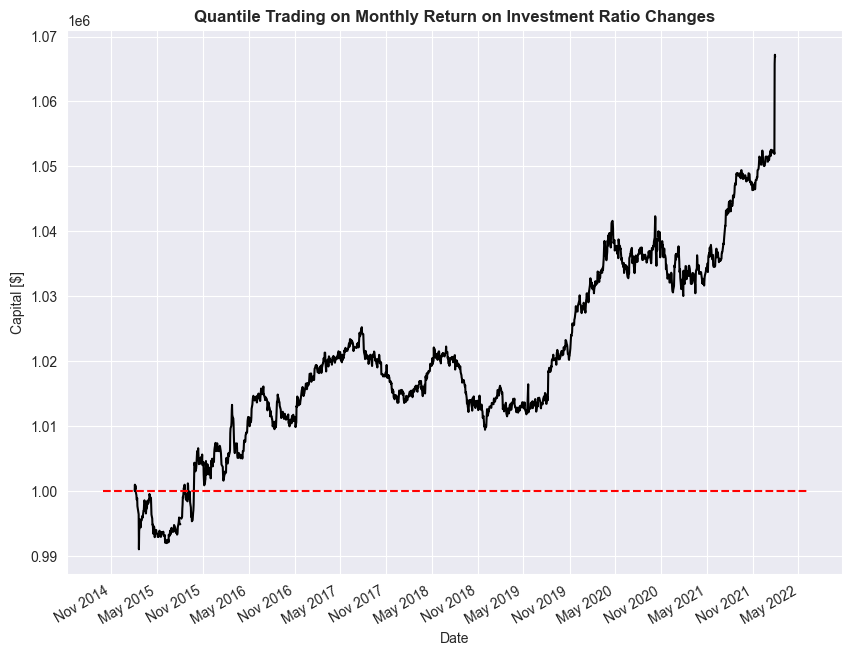

In [32]:
# set figure window
fig = plt.figure(figsize=(10,8))
# set axis
ax  = fig.add_subplot(111)
# time-series plot
ax.plot(trading_df2_2['Capital'], color = "black")
# capital line
abhline(capital, '--', 'red')
# x axis ticks and labels
ax.set_xlabel("Date", fontsize=10)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gcf().autofmt_xdate()
# y axis labels
ax.set_ylabel("Capital [$]", fontsize=10)
# title
ax.set_title("Quantile Trading on Monthly Return on Investment Ratio Changes", fontsize=12, fontweight = "bold")
None

This time the gains are mostly positive, as expected.
From this analysis, focusing on the changes in ROI seems to lead to a more profitable strategy than focusing on the
ROI itself.

<h5> <u> Performance Summary </u> </h5>

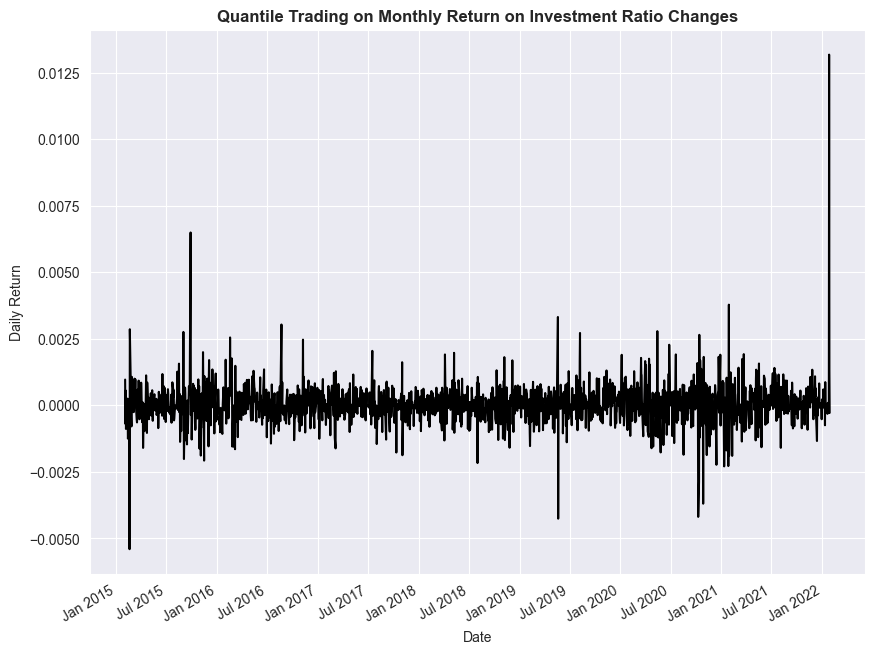

In [33]:
# set figure window
fig = plt.figure(figsize=(10,8))
# set axis
ax  = fig.add_subplot(111)
# time-series plot
ax.plot(trading_df2_2['Daily ROC'], color = "black")
# x axis ticks and labels
ax.set_xlabel("Date", fontsize=10)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gcf().autofmt_xdate()
# y axis labels
ax.set_ylabel("Daily Return", fontsize=10)
# title
ax.set_title("Quantile Trading on Monthly Return on Investment Ratio Changes", fontsize=12, fontweight = "bold")

None

In [34]:
summary_statistics(trading_df2_2[['Daily ROC']], interval = 'daily')

,Annualized $\mu$,Annualized $\sigma$,Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.025),CVaR (0.025),Min,Max,Max Drawdown
Daily ROC,0.013316,0.014729,0.904048,2.904334,53.927988,-0.001341,-0.086302,-0.005403,0.01318,-0.015401


The Max Drawdown and the annualized volatility is lower than before.
The CVaR (0.025) value is also lower in absolute value (higher in value) than before.
The mean is now positive at approximately 1.33% annual return.
Although the annualized mean return is not very high, it is still a more profitable and less volatile strategy.

<h3> 3-3. Price to Earnings </h3>

<h4> <i> Ranking by Value </i> </h4>

In [35]:
trading_df3 = quantile_trading('price to earnings', quant_df, low_to_high_rank = False)

A higher P/E ratio may suggest that the equity is over-priced and over-heated. Although there are cases of many
growing companies with high returns that also have a high P/E ratio due to abundance of intangible assets, this
analysis would look at shorting the top 10% companies with the highest P/E ratios and buying the bottom 10% companies
 with the lowest P/E ratios.

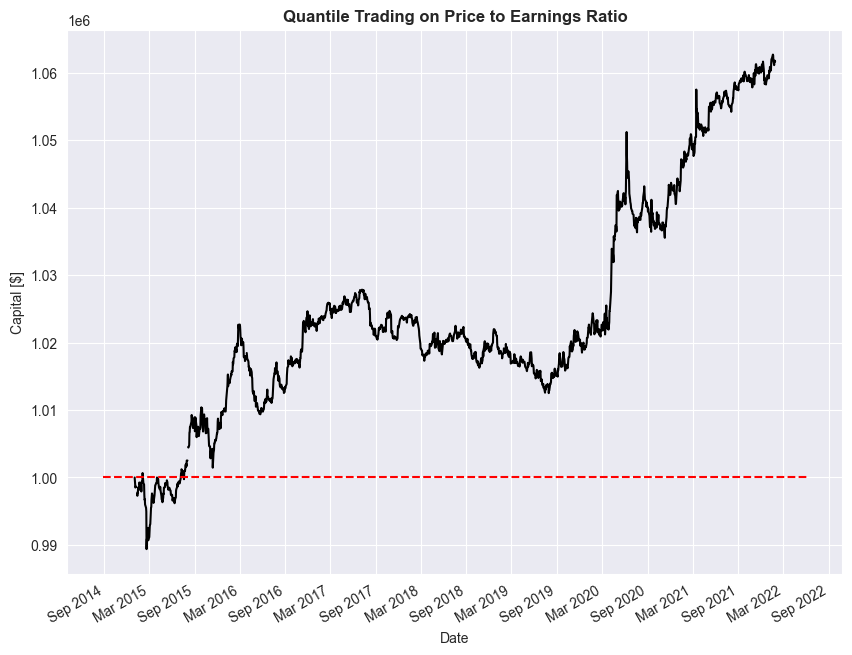

In [36]:
# set figure window
fig = plt.figure(figsize=(10,8))
# set axis
ax  = fig.add_subplot(111)
# time-series plot
ax.plot(trading_df3['Capital'], color = "black")
# capital line
abhline(capital, '--', 'red')
# x axis ticks and labels
ax.set_xlabel("Date", fontsize=10)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gcf().autofmt_xdate()
# y axis labels
ax.set_ylabel("Capital [$]", fontsize=10)
# title
ax.set_title("Quantile Trading on Price to Earnings Ratio", fontsize=12, fontweight = "bold")

None

The returns are mostly positive and does not experience sudden drops, with the exception of the time around March 2016.

<h5> <u> Performance Summary </u> </h5>

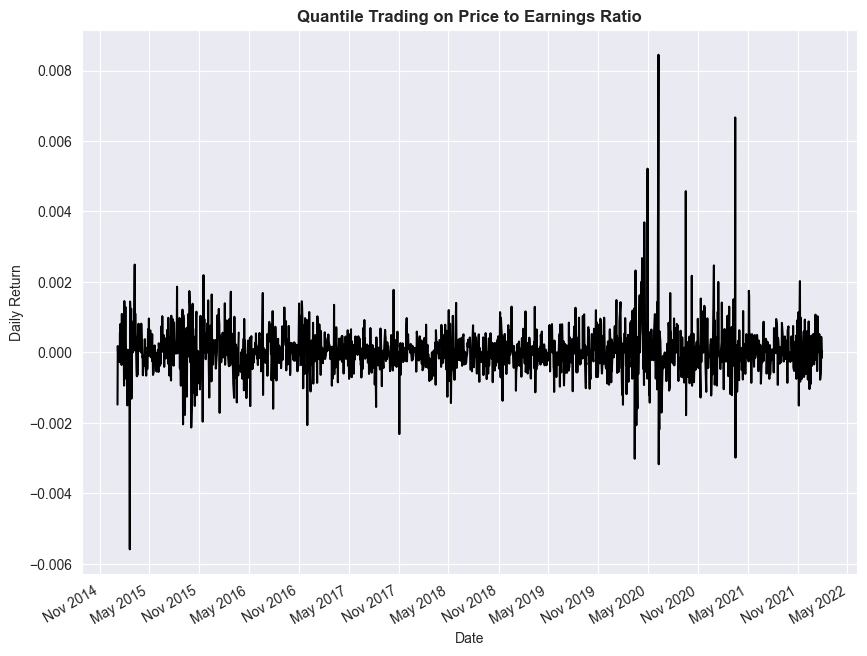

In [37]:
# set figure window
fig = plt.figure(figsize=(10,8))
# set axis
ax  = fig.add_subplot(111)
# time-series plot
ax.plot(trading_df3['Daily ROC'], color = "black")
# x axis ticks and labels
ax.set_xlabel("Date", fontsize=10)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gcf().autofmt_xdate()
# y axis labels
ax.set_ylabel("Daily Return", fontsize=10)
# title
ax.set_title("Quantile Trading on Price to Earnings Ratio", fontsize=12, fontweight = "bold")

None

In [38]:
summary_statistics(trading_df3[['Daily ROC']], interval = 'daily')

,Annualized $\mu$,Annualized $\sigma$,Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.025),CVaR (0.025),Min,Max,Max Drawdown
Daily ROC,0.01213,0.012882,0.941592,1.759179,25.7328,-0.001144,-0.077038,-0.005592,0.008448,-0.01492


The annualized return is positive with a lower annualized volatility compared to other strategies.
Though the Max Drawdown is low the CVaR (0.025) is still pretty high in absolute value.
Regardless, this strategy is the most profitable thus far, and seems to be the least volatile.

<h4> <i> Ranking by Changes </i> </h4>

In [39]:
trading_df3_2 = monthly_changes('price to earnings', quant_df, low_to_high_rank = False)

Aligned with the strategy above, this analysis will short the equities linked to companies that report decrease in
P/E ratio and buy the equities linked to companies that report increase in P/E ratio.

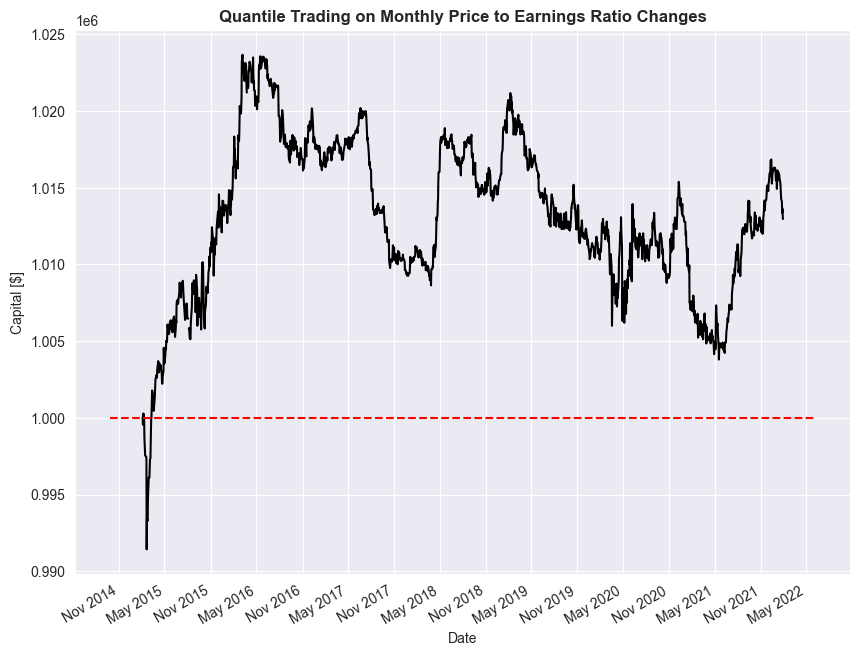

In [40]:
# set figure window
fig = plt.figure(figsize=(10,8))
# set axis
ax  = fig.add_subplot(111)
# time-series plot
ax.plot(trading_df3_2['Capital'], color = "black")
# capital line
abhline(capital, '--', 'red')
# x axis ticks and labels
ax.set_xlabel("Date", fontsize=10)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gcf().autofmt_xdate()
# y axis labels
ax.set_ylabel("Capital [$]", fontsize=10)
# title
ax.set_title("Quantile Trading on Monthly Price to Earnings Ratio Changes", fontsize=12, fontweight = "bold")

None

The returns are mostly positive following the sharp dip around May of 2015.
Though the returns fluctuate, they are still mostly above the initial capital line.
The overall gain was low; however, seems to exhibit drops and spikes in smaller magnitude.

<h5> <u> Performance Summary </u> </h5>

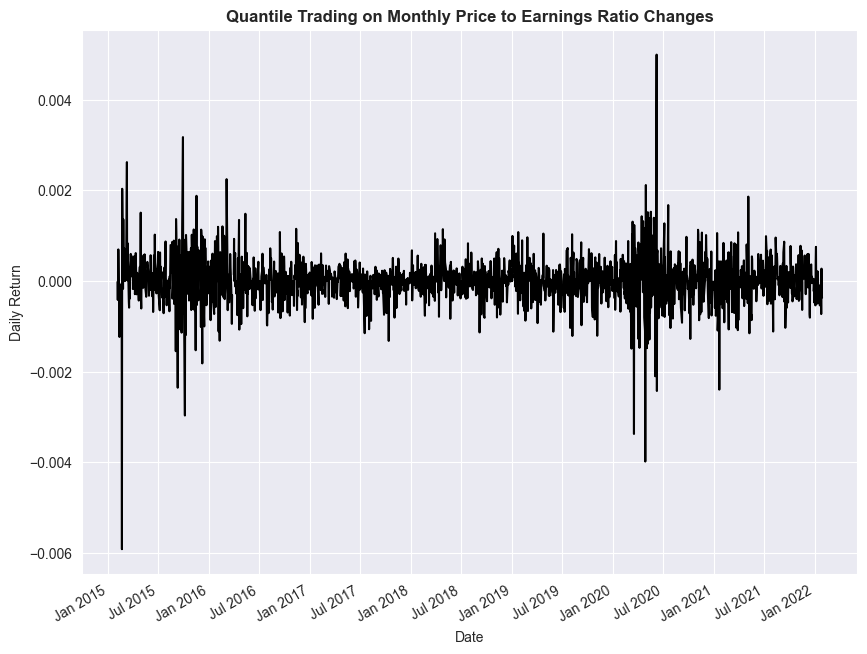

In [41]:
# set figure window
fig = plt.figure(figsize=(10,8))
# set axis
ax  = fig.add_subplot(111)
# time-series plot
ax.plot(trading_df3_2['Daily ROC'], color = "black")
# x axis ticks and labels
ax.set_xlabel("Date", fontsize=10)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gcf().autofmt_xdate()
# y axis labels
ax.set_ylabel("Daily Return", fontsize=10)
# title
ax.set_title("Quantile Trading on Monthly Price to Earnings Ratio Changes", fontsize=12, fontweight = "bold")

None

In [42]:
summary_statistics(trading_df3_2[['Daily ROC']], interval = 'daily')

,Annualized $\mu$,Annualized $\sigma$,Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.025),CVaR (0.025),Min,Max,Max Drawdown
Daily ROC,0.002806,0.010229,0.274297,-0.621491,17.568744,-0.001004,-0.069299,-0.005919,0.004995,-0.019667


The annualized average return is lower than before but the annualized volatility is also the lowest.
The CVaR and VaR values are also low.
Though the total and average returns are small, they are both still positive.
This strategy seems to exhibit a less risky set of returns.

<h3> 3-4. Return on Investment and Price to Earnings </h3>

In [43]:
trading_df4s = []
for w in [0, -0.5, -1.0, -1.5, -2.5, -3, -3.5, -4]:
    combination = {'return on investment': 1.0, 'price to earnings': w}
    trading_df4s.append(two_ratios(combination, quant_df, low_to_high_rank = True))

The intuition behind this combination is, similar to the strategy on return on investment, buying high return reporting
companies' stocks and shorting low return reporting companies' stocks. However, negatively combining with the Price
to Earning ratio would offset the ranking of companies that reported high returns in the last quarter, but has their
equities already over-priced.

The z-score from each ratio will be combined and re-ranked.

Seven different combinations were tried, each with a different magnitude of P/E penalty.

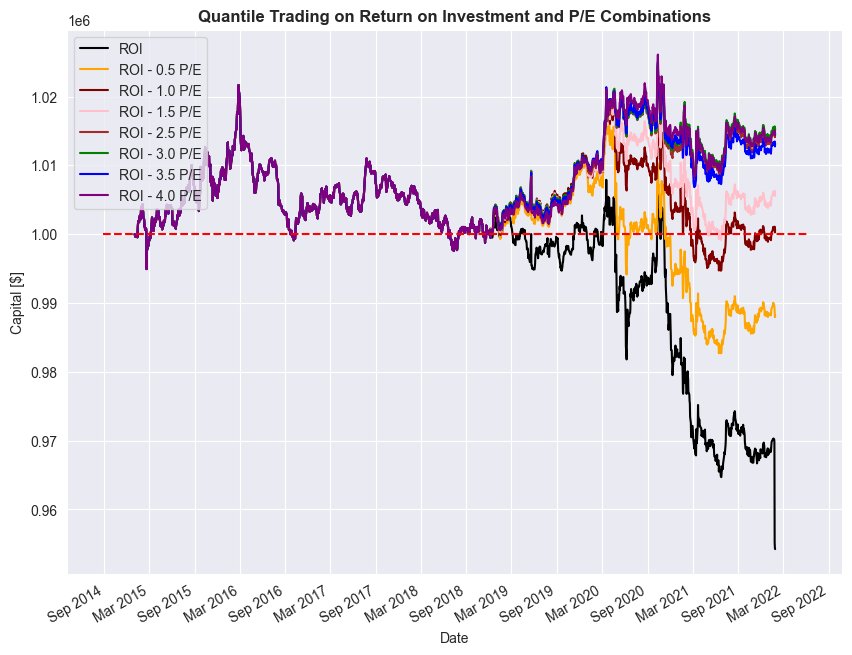

In [44]:
# set figure window
fig = plt.figure(figsize=(10,8))
# set axis
ax  = fig.add_subplot(111)
# time-series plot
ax.plot(trading_df4s[0]['Capital'], color = "black", label = "ROI")
ax.plot(trading_df4s[1]['Capital'], color = "orange", label = "ROI - 0.5 P/E")
ax.plot(trading_df4s[2]['Capital'], color = "maroon", label = "ROI - 1.0 P/E")
ax.plot(trading_df4s[3]['Capital'], color = "pink", label = "ROI - 1.5 P/E")
ax.plot(trading_df4s[4]['Capital'], color = "brown", label = "ROI - 2.5 P/E")
ax.plot(trading_df4s[5]['Capital'], color = "green", label = "ROI - 3.0 P/E")
ax.plot(trading_df4s[6]['Capital'], color = "blue", label = "ROI - 3.5 P/E")
ax.plot(trading_df4s[7]['Capital'], color = "purple", label = "ROI - 4.0 P/E")
# include legend
ax.legend(loc = "upper left")
# capital line
abhline(capital, '--', 'red')
# x axis ticks and labels
ax.set_xlabel("Date", fontsize=10)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gcf().autofmt_xdate()
# y axis labels
ax.set_ylabel("Capital [$]", fontsize=10)
# title
ax.set_title("Quantile Trading on Return on Investment and P/E Combinations", fontsize=12, fontweight = "bold")

None

All seven variations of ROI and P/E combination seem to track each other very closely until around March 2019.
However, past March 2019, the negative P/E combinations differentiate themselves from the pure ROI quantile trading
strategy.

The three combinations $z_{ROI} - 3 \cdot z_{P/E}$, $z_{ROI} - 3.5 \cdot z_{P/E}$, and $z_{ROI} - 4 \cdot z_{P/E}$
are most frequently above the capital line.

Let's compare the summary statistics of the three.

In [45]:
print(">>> ROI - 3.0 P/E Summary Statistics")
summary_statistics(trading_df4s[5][['Daily ROC']], interval = 'daily')

>>> ROI - 3.0 P/E Summary Statistics


,Annualized $\mu$,Annualized $\sigma$,Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.025),CVaR (0.025),Min,Max,Max Drawdown
Daily ROC,0.003067,0.013438,0.228256,0.207613,11.520671,-0.00141,-0.093827,-0.005442,0.00521,-0.023944


In [46]:
print(">>> ROI - 3.5 P/E Summary Statistics")
summary_statistics(trading_df4s[6][['Daily ROC']], interval = 'daily')

>>> ROI - 3.5 P/E Summary Statistics


,Annualized $\mu$,Annualized $\sigma$,Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.025),CVaR (0.025),Min,Max,Max Drawdown
Daily ROC,0.002629,0.013258,0.198275,0.07626,10.991369,-0.00141,-0.093293,-0.005442,0.005168,-0.023944


In [47]:
print(">>> ROI - 4.0 P/E Summary Statistics")
summary_statistics(trading_df4s[7][['Daily ROC']], interval = 'daily')

>>> ROI - 4.0 P/E Summary Statistics


,Annualized $\mu$,Annualized $\sigma$,Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.025),CVaR (0.025),Min,Max,Max Drawdown
Daily ROC,0.002949,0.013236,0.222786,0.096558,11.200788,-0.00141,-0.092789,-0.005442,0.005274,-0.023944


$z_{ROI} - 3 \cdot z_{P/E}$ reports the highest annualized average return and Sharpe Ratio.
All three are positively skewed but much closer to symmetric compared to other strategies.
Of the three, from this analysis, $z_{ROI} - 3 \cdot z_{P/E}$ seems to be the optimal combination.